In [2]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.linalg as jsl

from PTA import PTA
from likelihood import Likelihood, get_likelihood_obj

import numpyro
import numpyro.distributions as dist
from numpyro.infer.initialization import init_to_value

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

# use double precision
config.update('jax_enable_x64', True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# make PTA and likelihood objects
pta = PTA(Np=5, Tspan_yr=15., Nf=5)
l = get_likelihood_obj(pta)

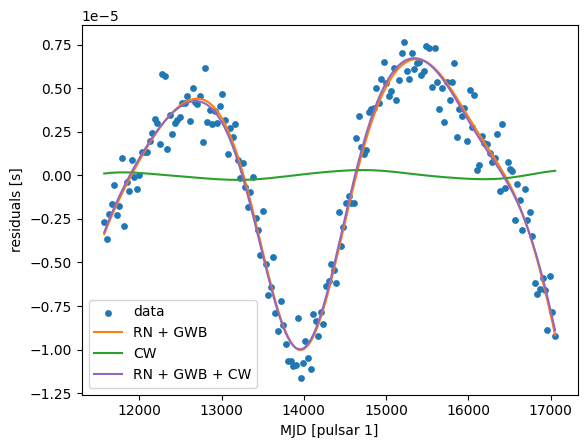

In [22]:
# plot data and injected signals
psr_ndx = 0
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')
if pta.model_gwb or pta.model_rn:
    rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if pta.model_cw:
    cw_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.get_CW_coefficients(pta.x_inj[pta.cw_psr_ndxs])[psr_ndx]
    plt.plot(pta.MJDs[psr_ndx], cw_residuals_inj, color='C2', label='CW')
if (pta.model_gwb or pta.model_rn) and pta.model_cw:
    plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [23]:
# posterior density
@jit
def lnpost(x):

    # unpack parameters
    efacs = x[pta.efac_ndxs]
    rn_hypers = x[pta.rn_ndxs]
    gwb_hypers = x[pta.gwb_ndxs]
    cw_psr_params = x[pta.cw_psr_ndxs]
    psr_dists = x[pta.psr_dist_ndxs]
    a = x[pta.a_ndxs]

    # prior
    lnprior_val = l.uniform_lnprior(x)
    lnprior_val += l.a_lnprior_rn_gwb(rn_hypers, gwb_hypers, a)
    lnprior_val += l.psr_dist_lnprior(psr_dists)

    # likelihood
    a_cw = pta.get_CW_coefficients(cw_psr_params).flatten()
    lnlike_val = l.lnlike(efacs, a + a_cw)

    return lnprior_val + lnlike_val

vectorized_lnpost = jit(vmap(lnpost))

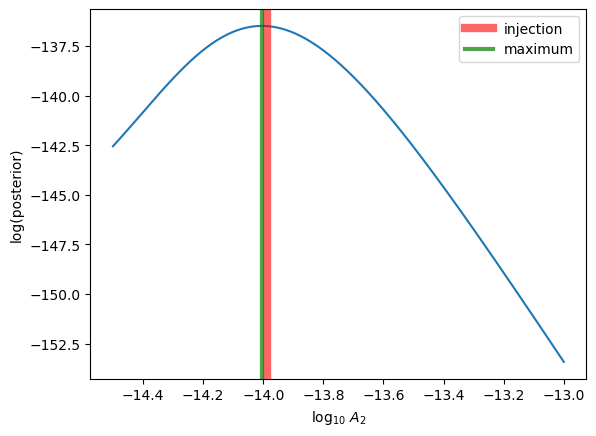

In [24]:
# plot cross-section of posterior
param_ndx = 7
num_evals = 1000
param_vals = jnp.linspace(pta.x_mins[param_ndx], pta.x_maxs[param_ndx], num_evals)
params = jnp.tile(pta.x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(pta.x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(pta.x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

In [46]:
@jit
def transform_a(rn_hypers, gwb_hypers, a_standard):
    rn_phi = jnp.zeros((pta.Na, pta.Np, pta.Np))
    rn_phi = rn_phi.at[:, jnp.arange(pta.Np), jnp.arange(pta.Np)].set(pta.vectorized_get_rho_diag(rn_hypers.reshape((pta.Np, 2))).T)
    gwb_phi = pta.get_rho_diag(gwb_hypers)[:, None, None] * pta.alpha[None, :, :]
    phi = rn_phi + gwb_phi + jnp.ones((pta.Na))[:, None, None] * jnp.eye(pta.Np, pta.Np)[None, :, :] * 1.e-6
    Lc = vmap(lambda x: jsl.cholesky(x, lower=True))(phi)
    a_transformed = vmap(lambda L, x: L @ x)(Lc, a_standard.reshape((pta.Np, pta.Na)).T).T.flatten()
    return a_transformed

In [47]:
def sampling_model():
    # uniform prior on hyper-parameters
    efacs = numpyro.sample('efacs', dist.Uniform(pta.efac_mins, pta.efac_maxs))
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta.rn_mins, pta.rn_maxs))
    gwb_hypers = numpyro.sample('gwb_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))

    # uniform prior on CW parameters and pulsar phases
    cw_params = numpyro.sample('cw', dist.Uniform(pta.cw_mins, pta.cw_maxs))
    psr_phases = numpyro.sample('psr_phases', dist.Uniform(pta.psr_phase_mins, pta.psr_phase_maxs))

    # normal prior on pulsar distances
    psr_dists = numpyro.sample('psr_dists', dist.Normal(pta.psr_dists_inj, pta.psr_dists_stdev))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na_PTA]))
    a_transformed = transform_a(rn_hypers, gwb_hypers, a_standard)
    a = numpyro.deterministic('a', a_transformed)

    # get CW coefficients
    a_cw = pta.get_CW_coefficients(jnp.concatenate((cw_params, psr_phases, psr_dists))).flatten()

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(efacs, a + a_cw))

In [48]:
# injected parameters in dictionary amenable to sampler
x_inj_dict = {'efacs':pta.efacs_inj, 'rn_hypers':pta.rn_inj, 'gwb_hypers':pta.gwb_inj,
              'cw':pta.cw_inj, 'psr_phases':pta.psr_phases_inj, 'psr_dists':pta.psr_dists_inj,
              'a_standard':jnp.zeros(pta.Na_PTA)}

In [49]:
# nuts_kernel = numpyro.infer.NUTS(sampling_model, dense_mass=[('rn_hypers',), ('gwb_hypers',), ('cw',)])
# nuts_kernel = numpyro.infer.NUTS(sampling_model)
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 init_strategy=init_to_value(values=x_inj_dict),
                                 dense_mass=[('rn_hypers',), ('gwb_hypers',), ('cw',)])
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e3),
                          num_samples=int(1e3))
mcmc.run(jr.key(113))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [01:01<00:00, 32.59it/s, 511 steps of size 6.46e-03. acc. prob=0.81] 


In [50]:
samples = np.concatenate((samples_dict['efacs'],
                          samples_dict['rn_hypers'],
                          samples_dict['gwb_hypers'],
                          samples_dict['cw'],
                          samples_dict['psr_phases'],
                          samples_dict['psr_dists'],
                          samples_dict['a']), axis=1)

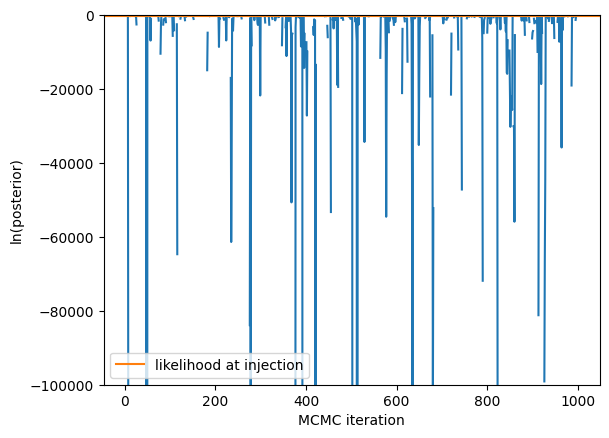

In [56]:
# plot posterior values
# lnposts = vectorized_lnpost(samples)
lnposts = jnp.array([lnpost(x) for x in samples])
plt.plot(lnposts)
plt.axhline(lnpost(pta.x_inj), label='likelihood at injection', color='C1')
plt.xlabel('MCMC iteration')
plt.ylabel('ln(posterior)')
plt.legend()
plt.ylim(-100_000., 0.)
plt.show()

In [58]:
print(np.where(np.isinf(lnposts)))

(array([  0,   1,   2,   4,   6,   9,  12,  13,  14,  16,  17,  19,  21,
        23,  27,  28,  30,  31,  33,  35,  36,  44,  45,  46,  52,  53,
        54,  59,  60,  63,  64,  65,  67,  69,  71,  72,  73,  76,  77,
        78,  82,  83,  84,  88,  89,  92,  94, 101, 102, 103, 107, 110,
       111, 112, 113, 114, 117, 121, 122, 125, 126, 127, 128, 129, 131,
       134, 135, 138, 139, 140, 142, 144, 146, 147, 148, 149, 153, 155,
       157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 184, 187,
       190, 191, 192, 193, 194, 195, 197, 198, 200, 201, 202, 203, 204,
       211, 213, 214, 217, 220, 226, 227, 228, 229, 233, 241, 242, 243,
       244, 245, 250, 254, 256, 259, 260, 261, 262, 264, 266, 267, 268,
       270, 271, 272, 273, 274, 275, 281, 283, 288, 290, 291, 296, 301,
       302, 303, 304, 305, 306, 307, 308, 311, 312, 314, 317, 320, 321,
       322, 324, 327, 328, 329, 330, 335, 336, 337, 338, 341, 3

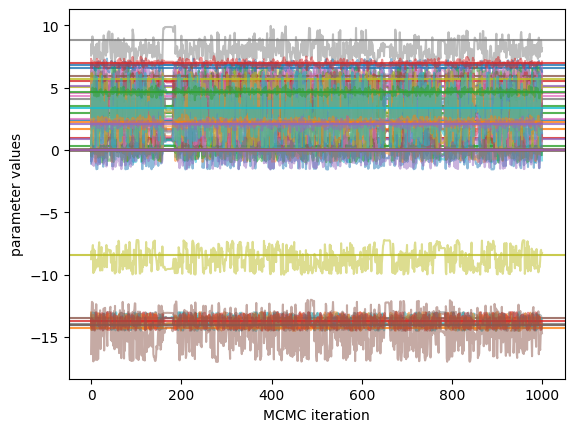

In [59]:
# trace plot
for i in range(pta.ndim):
    plt.plot(samples[:, i], color=f'C{i}', alpha=0.5)
    plt.axhline(pta.x_inj[i], color=f'C{i}', alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter values')
plt.show()

In [60]:
# plot auto-correlations
auto_corrs = np.array([integrated_time(samples[:, i])[0] for i in range(m.ndim)])
plt.bar(np.arange(m.ndim), auto_corrs)
plt.xlabel('parameter index')
plt.ylabel('auto-correlation')
plt.show()

NameError: name 'm' is not defined

Parameter $\log_{10}(\mathcal{M}\,\,[M_\odot])$ in chain HMC is not constrained
Parameter $\log_{10}(f_{GW}\,\,[\text{Hz}])$ in chain HMC is not constrained
Parameter $\cos{\iota}$ in chain HMC is not constrained
Parameter $\psi$ in chain HMC is not constrained
Parameter $\log_{10}(D_{L}\,\,[\text{Mpc}])$ in chain HMC is not constrained
Parameter $\cos{\theta}$ in chain HMC is not constrained
Parameter $\phi$ in chain HMC is not constrained
Parameter $\Phi_0$ in chain HMC is not constrained


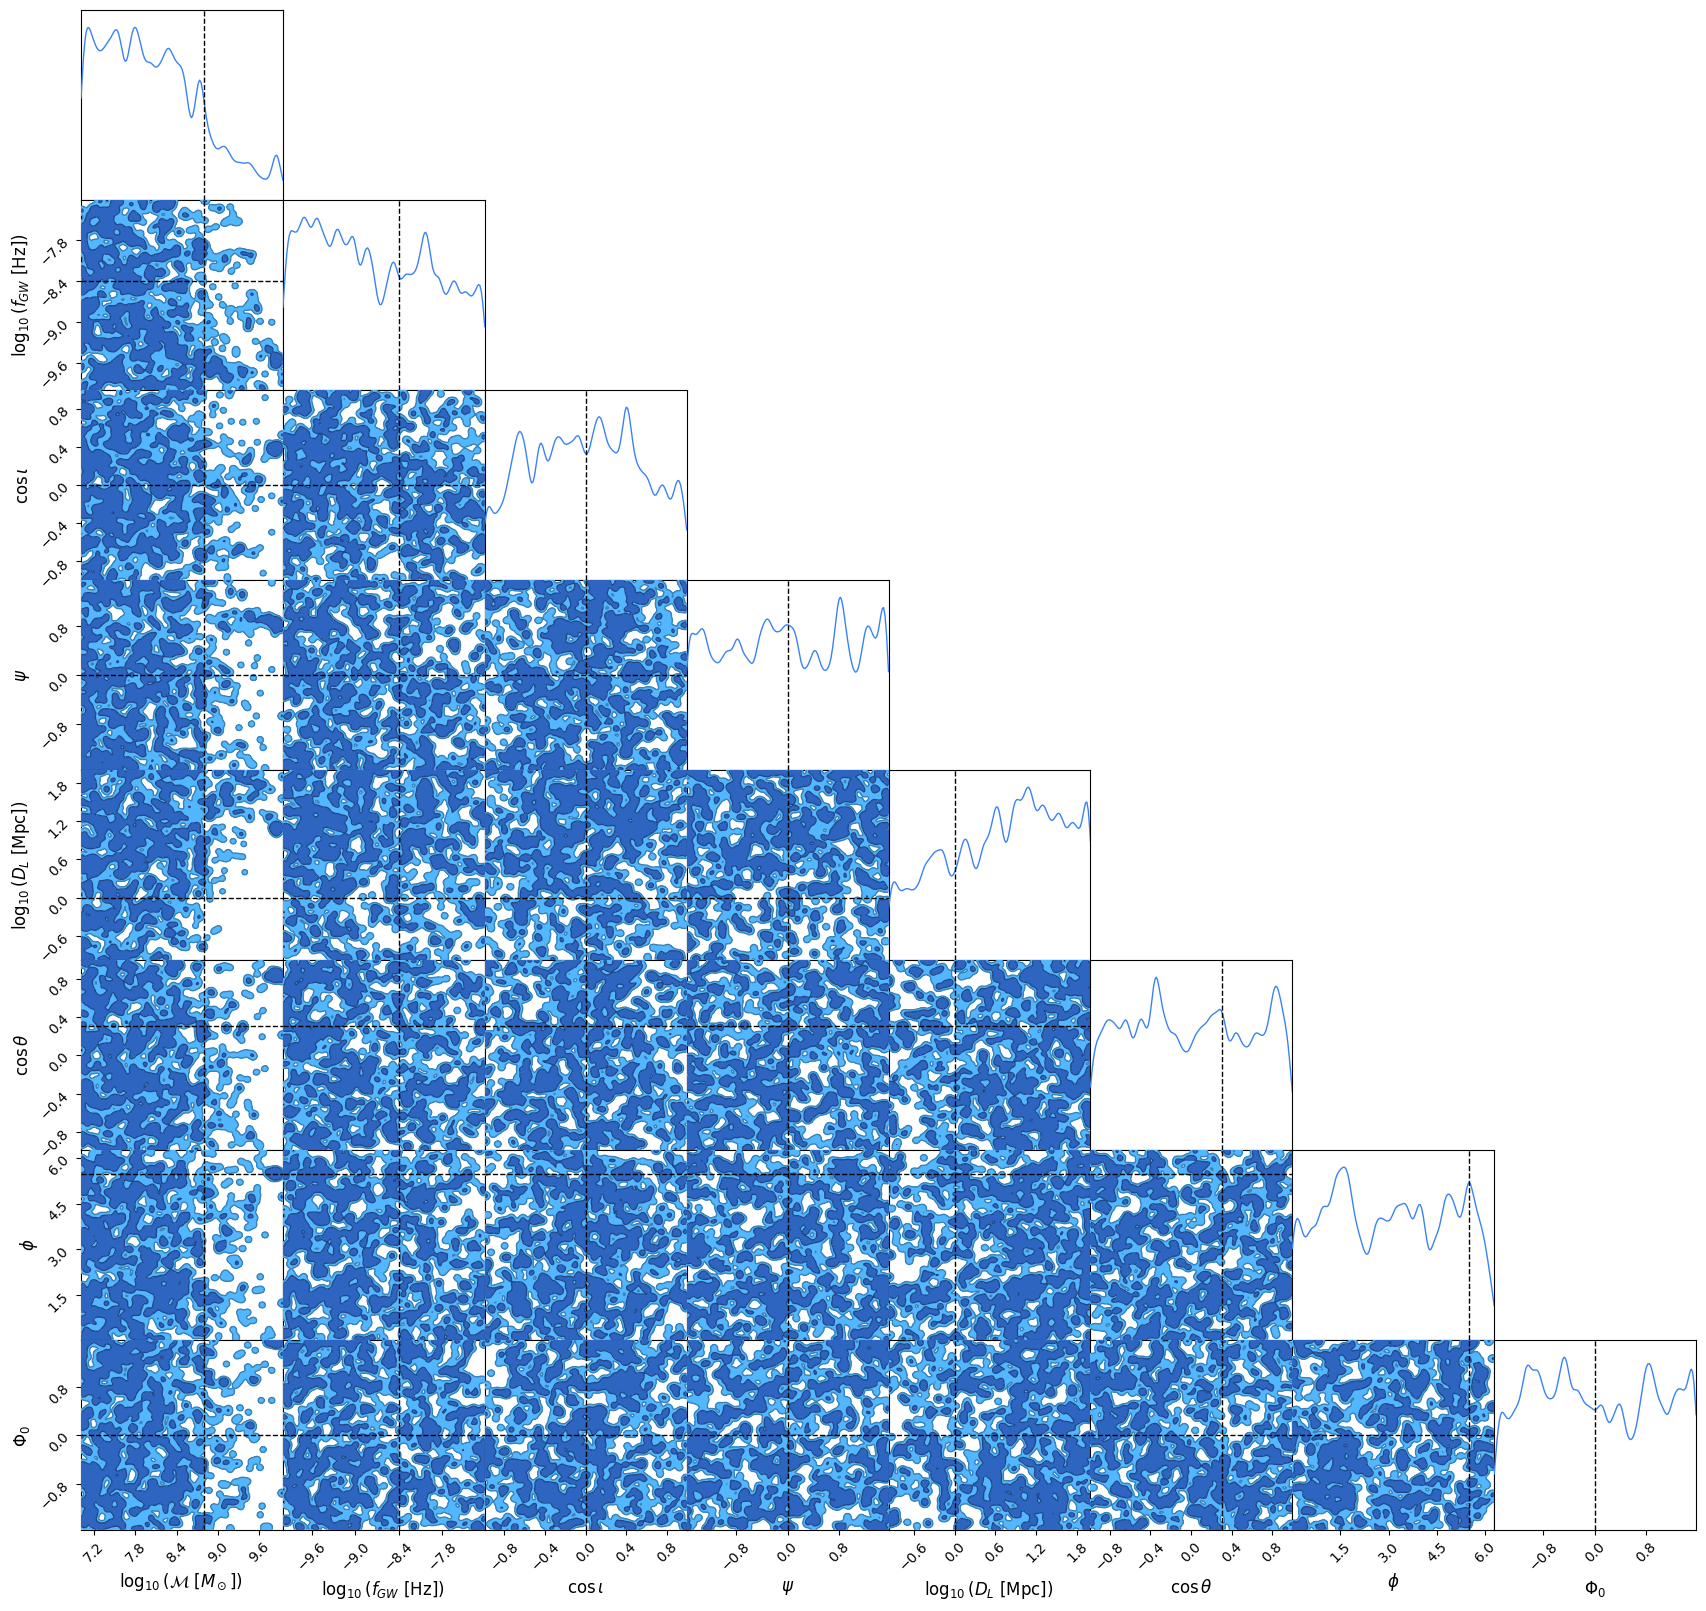

In [61]:
# corner plot
# ndxs = np.concatenate((m.rn_ndxs[:6], m.gwb_ndxs, m.cw_ndxs[:2]))
ndxs = pta.cw_ndxs
# ndxs = np.concatenate((m.rn_ndxs[:2], m.a_ndxs[:2], m.a_ndxs.reshape((m.Np, m.Na))[0][-8:-1]))
df = pd.DataFrame(samples, columns=pta.x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df.iloc[:, ndxs], name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(pta.x_labels, pta.x_inj)}))
fig = c.plotter.plot()

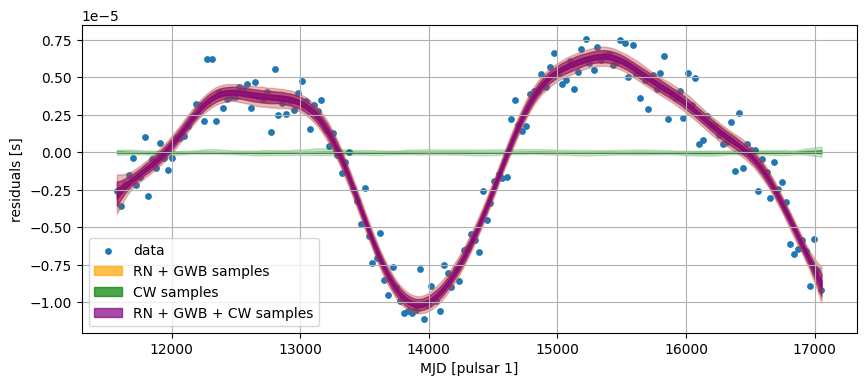

In [22]:
# Bayesogram
psr_ndx = 0
fair_draw_ndxs = np.random.choice(samples.shape[0], (1000,))
a_cws = np.array([m.get_CW_coefficients(samples[ndx, m.cw_psr_ndxs])[psr_ndx]
                  for ndx in fair_draw_ndxs])
rn_gwb_signals = np.array([m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ samples[ndx, m.a_ndxs].reshape((m.Np, m.Na))[psr_ndx]
                           for ndx in fair_draw_ndxs])
cw_signals = np.array([m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ a_cw for a_cw in a_cws])
signals = cw_signals + rn_gwb_signals

# percentile layers for plotting densities of samples
percentile_layers = [2.5, 10., 30.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(m.MJDs[psr_ndx], m.Rs[psr_ndx] @ residuals[psr_ndx], color='C0', s=15, label='data')

# Bayesogram for RN + GWB
for percentile, alpha in zip(percentile_layers, alphas):
    if percentile != percentile_layers[-1]:
        plt.fill_between(m.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='orange', alpha=alpha)
    else:
        plt.fill_between(m.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='orange', alpha=alpha, label='RN + GWB samples')

# Bayesogram for CW
for percentile, alpha in zip(percentile_layers, alphas):
    if percentile != percentile_layers[-1]:
        plt.fill_between(m.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                        np.percentile(cw_signals, 100. - percentile, axis=0),
                        color='green', alpha=alpha)
    else:
        plt.fill_between(m.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                        np.percentile(cw_signals, 100. - percentile, axis=0),
                        color='green', alpha=alpha, label='CW samples')

# Bayesogram for RN + GWB + CW
for percentile, alpha in zip(percentile_layers, alphas):
    if percentile != percentile_layers[-1]:
        plt.fill_between(m.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                        np.percentile(signals, 100. - percentile, axis=0),
                        color='purple', alpha=alpha)
    else:
        plt.fill_between(m.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                        np.percentile(signals, 100. - percentile, axis=0),
                        color='purple', alpha=alpha, label='RN + GWB + CW samples')

rn_gwb_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.a_inj.reshape((m.Np, m.Na))[psr_ndx]
cw_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.get_CW_coefficients(m.x_inj[m.cw_psr_ndxs])[psr_ndx]
# plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C1', label='RN + GWB + CW injection')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()